Este projeto tem como objetivo apresentar fundamentos de webscrapping [1],[2],[3] e regex [4],[5] para a leitura de uma tabela verdade [6], que siga o formato de 'tabela.csv' e tenha de 2 a 6 variáveis, e obtenha a equação booleana simplificada para a implementação em sketch .ino [7]. A equação booleana é obtida por meio da aplicação web http://www.32x8.com/index.html .
    
    REFERÊNCIAS:
[1] https://www.crummy.com/software/BeautifulSoup/bs4/doc/#  

[2] https://www.w3schools.com/cssref/css_selectors.asp

[3] https://developers.google.com/web/tools/chrome-devtools

[4] https://docs.python.org/3/library/re.html 

[5] https://regexone.com/

[6] https://www.electronics-tutorials.ws/boolean/bool_7.html

[7] https://playground.arduino.cc/Code/BitMath/

In [1]:
import requests                  #pip install requests - > realiza requisições HTTP
from bs4 import BeautifulSoup    #pip install beautifulsoup4 - > permite a navegação no DOM das páginas obtidas pela requests
import re                        #não requer instalação - > manipulação de regexes
import os                        #não requer instalação - > manipulação de diretórios

                            VERIFICAÇÃO SE SITE COM SOLVER DE MAPA DE KARNAUGH ESTÁ VÁLIDO
            
    Neste primeiro momento, é verificado se a requisição (GET) para a página inicial da aplicação retorna conteúdo esperado. Primeiramente, é inicializada uma sessão (session) para realizarmos as requisições para esta aplicação. Após realizarmos o GET na página inicial, o texto do .html obtido como resposta é parseado no objeto soup. Se o texto do primeiro elemento da lista referente ao CSS Selector '#intro > h1' for 'Logic circuit simplification' (como visto na Figura 1), estamos de fato navegando na aplicação de interesse
    

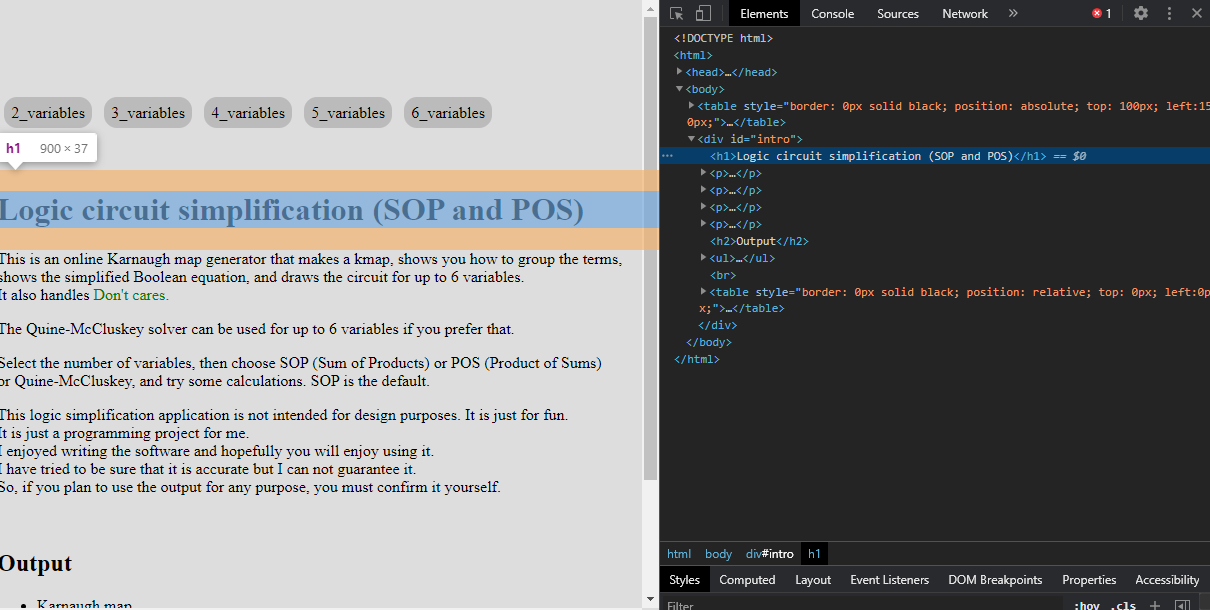

 Figura 1 - Ferramentas do desenvolvedor do Google Chrome com destaque do elemento para verificação da validade da sessão

In [2]:
session = requests.Session()
req = session.get('http://www.32x8.com/index.html')
soup = BeautifulSoup(req.text, 'html.parser')
if 'Logic circuit simplification' in soup.select('#intro > h1',text=True)[0].text:
    print('Site valido')
else:
    print('Site invalido')

Site valido


                    VERIFICAÇÃO SE É UM INPUT .csv VÁLIDO
O caminho relativo com a tabela verdade de interesse deve ser passado em filename. As linhas desta serão lidas no objeto data. A primeira linha, data[0], será lida a partir de "LINHA;" (ou seja, utilizaremos o segundo elemento deste split para identificar quais serão as entradas). Em seguida, é feito um outro split por regex para identificar os elementos antes do sinal de saída na tabela verdade, denotado por VY ou apenas Y. O tamanho da lista resultante terá a quantidade de entradas na tabela verdade deste formato

In [3]:
filename = 'tabela.csv'
with open (filename, "r") as myfile:
    data=myfile.readlines()
myfile.close()
num_var = len(re.split(r";V?Y",data[0].split("LINHA;")[1])[0].split(";"))
if num_var >=2 or  num_var<=6:
    print(f'Numero de variaveis {num_var} valido')
else:
    print(f'Numero de variaveis {num_var} invalido')

Numero de variaveis 4 valido


                PARSEANDO FORM DATA DA REQUISIÇÃO
As linhas de conteúdo lidas anteriormente, data[1:], terão caracteres de quebra de linha (\n) removidos e serão divididas conforme o separador ';' das colunas do csv. Em seguida, utilizando-se de compreensão de dicionários, será preenchido um dicionário com o form data enviado no POST exemplificado pela Figura 2. Observe que o par chave-valor relativo às linhas da tabela verdade é constituído por 'in'+binario_entradas e o valor de y, respectivamente. As chaves calctype e drawtype possuem valores fixos.

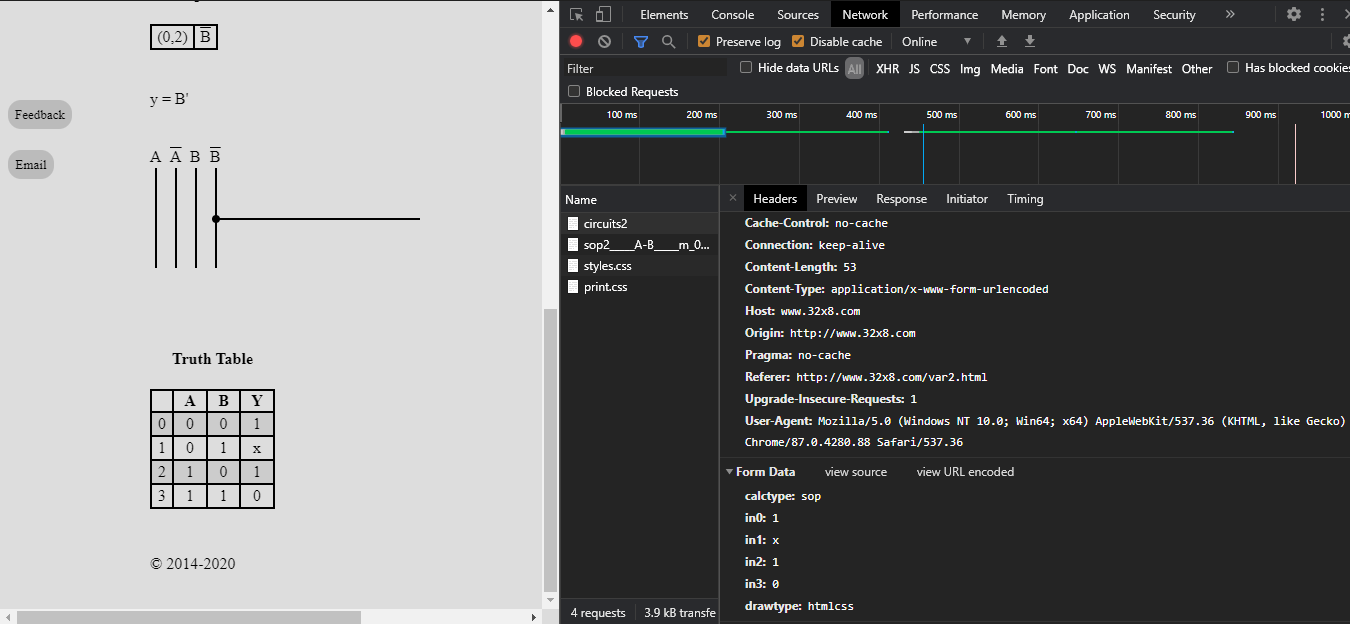

Figura 2 - Ferramentas do desenvolvedor do Google Chrome com exemplo do POST para a solução de uma tabela verdade de 2 variáveis

In [4]:
data = [x.replace('\n','').split(';')[1:] for x in data[1:]]
body = {('in'+str(int(''.join(x[0:num_var]),2))):x[num_var] for x in data}
body['calctype'] = 'sop'
body['drawtype'] = 'htmlcss'
print(body)

{'in0': '1', 'in1': '1', 'in2': '0', 'in3': '0', 'in4': '1', 'in5': '0', 'in6': '1', 'in7': '0', 'in8': '1', 'in9': '1', 'in10': '1', 'in11': '0', 'in12': '1', 'in13': '0', 'in14': '1', 'in15': '1', 'calctype': 'sop', 'drawtype': 'htmlcss'}


            FAZENDO REQUISIÇÃO PARA OBTER SIMPLIFICAÇÃO DA TABELA VERDADE
Para settar corretamente os cookies da sessão, é realizado inicialmente um GET para a página com a quantidade de entradas da tabela verdade. Em seguida, é feito um POST para circuits + número de variáveis deste domínio com o form data parseado anteriormente.

In [5]:
session.get("http://www.32x8.com/var" + str(num_var) + ".html")
resp = session.post("http://www.32x8.com/circuits" + str(num_var),data=body)

            OBTENDO EQUAÇÃO DA PÁGINA DE RESPOSTA
A equação eq é obtida pelo CSS Selector '#sop > div > div:nth-child(5)' da página obtida do POST. Por meio de regexes e substrings, o NOT de alguma entrada é formatado para '!entrada' e é introduzido o operador de multiplicação * a fim de garantir compatibilidade com a sintaxe em C do .ino

In [6]:
soup = BeautifulSoup(resp.text, 'html.parser')
eq = re.sub(r"(\w{1})'",r"!\1",soup.select('#sop > div > div:nth-child(5)')[0].text)
eq = 'boolean y = '+'+'.join([(re.sub(r'(!?\w{1})',r'\1*',x.strip()))[0:-1] for x in eq.split('=')[1].split('+')])+';'
print(eq)

boolean y = !B*!C+B*!D+A*!D+A*B*C;


            PREENCHENDO .ino
A string template_ino será modificada para incluir a declaração dos bits de entrada em [in] no registrador PORTD, a leitura dessas entradas em [in_read] e a equação obtida anteriormente em [eq]. 

In [7]:
template_ino = 'void setup() {\nDDRB |= (1<<0);\n[in]\n}\n\nvoid loop() {\n[in_read]\n[eq]\nPORTB = (y<<0);\n}'
print(template_ino)

void setup() {
DDRB |= (1<<0);
[in]
}

void loop() {
[in_read]
[eq]
PORTB = (y<<0);
}


In [8]:
in_str = ''
in_read_str = ''
for i in range(0,num_var):
    in_str += f'DDRD &= -(1<<{2+i});\n'
    in_read_str += f'boolean {chr(i+65)} = (PIND &(1<<{2+i}));\n'
    
print(in_str)
print(in_read_str)

DDRD &= -(1<<2);
DDRD &= -(1<<3);
DDRD &= -(1<<4);
DDRD &= -(1<<5);

boolean A = (PIND &(1<<2));
boolean B = (PIND &(1<<3));
boolean C = (PIND &(1<<4));
boolean D = (PIND &(1<<5));



In [9]:
template_ino = template_ino.replace('[in]',in_str).replace('[in_read]',in_read_str).replace('[eq]',eq)
print(template_ino)

void setup() {
DDRB |= (1<<0);
DDRD &= -(1<<2);
DDRD &= -(1<<3);
DDRD &= -(1<<4);
DDRD &= -(1<<5);

}

void loop() {
boolean A = (PIND &(1<<2));
boolean B = (PIND &(1<<3));
boolean C = (PIND &(1<<4));
boolean D = (PIND &(1<<5));

boolean y = !B*!C+B*!D+A*!D+A*B*C;
PORTB = (y<<0);
}


In [10]:
ino_path = os.path.join(os.curdir,filename.split('.')[0])
if not(os.path.isdir(ino_path)):
    os.mkdir(ino_path)
os.chdir(ino_path)
with open(filename.split('.')[0]+'.ino','w') as ino_file:
    ino_file.write(template_ino)
ino_file.close()

Por fim, o diretório com o .ino gerado poderá ser aberto pela Arduino IDE e carregado para a placa, conforme ilustrado pela Figura 3.

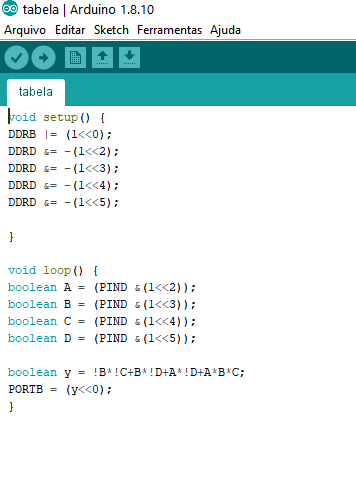

                                        Figura 3 - Abertura na IDE do arquivo gerado